In [1]:
include("./PeriodicKdV.jl")
using .PeriodicKdV
using LinearAlgebra, Plots, Printf
using ApproxFun

In [2]:
y2 = λ -> y21(λ^2) + y22(λ^2)
dy2 = λ -> imag(y2(λ + 1im*1e-14)/1e-14)
y21 = λ -> 1/sqrt(λ)*cos(sqrt(λ-1))*sin(sqrt(λ))
y22 = λ -> 1/sqrt(λ-1)*cos(sqrt(λ))*sin(sqrt(λ-1))
# dy21 = λ -> -0.5/λ^(3/2)*cos(sqrt(λ-1))*sin(sqrt(λ)) - 0.5/sqrt(λ^2-λ)*sin(sqrt(λ-1))*sin(sqrt(λ)) + 0.5/sqrt(λ^2)*cos(sqrt(λ-1))*cos(sqrt(λ))

Δ1 = λ -> 2*cos(sqrt(λ-1))*cos(sqrt(λ))
Δ2 = λ -> - (2*λ-1)/sqrt(λ^2-λ)*sin(sqrt(λ))*sin(sqrt(λ-1))
Δ = λ ->  Δ1(λ |> complex) + Δ2(λ |> complex) |> real
T22 = λ -> cos(sqrt(λ))*cos(sqrt(λ-1)) - sqrt(λ-1)/sqrt(λ)*sin(sqrt(λ-1))*sin(sqrt(λ))
T11 = λ -> Δ(λ) - T22(λ)

dΔ = λ -> mag(Δ(λ + 1im*1e-14)/1e-14)

#19 (generic function with 1 method)

In [3]:
prec = 500
sp(x) = BigFloat(x,prec)
spc(x) = BigFloat(real(x),prec)+1im*BigFloat(imag(x),prec)

spc (generic function with 1 method)

In [4]:
function Newton(f,df,x0,eps,nmax)
    x = x0
    for i = 1:nmax
        δ = -f(x)/df(x)
        if abs(δ) < eps
            return x + δ
        else
            x = x + δ
        end
    end
    if abs(f(x)) > 1e-15
        @warn "failed to converge"
    end
    return x
end

function Bisection(f,A,B,nmax)
    a = A; b = B;
    if abs(f(a)) < 1e-32
        return a
    elseif abs(f(b)) < 1e-32
        return b
    end
    c = a;
    for i = 1:nmax
        fa = f(a); 
        fb = f(b);
        c = (a + b)/2;
        fc = f(c)
        #println((fa,fc,fb))
        #println((a,c,b))
        if fa*fc > 0
            a = c
        else
            b = c
        end
    end
    c
end

Bisection (generic function with 1 method)

In [5]:
target_g = 500
z1 = Newton(y2,dy2,sqrt(3.0),1e-15,100)
zs = [z1];
for i = 1:target_g
    x0 = zs[end] + pi/2
    x0 = Newton(y2,dy2,x0,1e-15,100)
    zs = vcat(zs,[x0])
end

In [6]:
abs.(zs[2:end] - zs[1:end-1]) |> minimum |> display
abs.(zs[2:end] - zs[1:end-1]) |> maximum |> display

1.5078544029561054

1.570795691188664

In [7]:
target_g = 500
z1 = Newton(y2,dy2,sqrt(3 |> sp ),1e-32,100)
zs = [z1];
for i = 1:target_g
    x0 = zs[end] + pi/2
    x0 = Newton(y2,dy2,x0,1e-32,100)
    zs = vcat(zs,[x0])
end
zs = zs.^2

gs = [Bisection(λ -> Δ(λ) - 2,0.00001 |> sp ,zs[1] |> sp ,60) |> Float64, Bisection(λ -> Δ(λ) + 2,0.00001 |> sp,zs[1] |> sp,60) |> Float64] 
for i = 0:target_g-1
    gs = vcat(gs,[Bisection(λ -> Δ(λ) + 2,zs[i+1] |> sp,zs[i+2] |> sp,60) |> Float64, Bisection(λ -> Δ(λ) - 2,zs[i+1] |> sp,zs[i+2] |> sp,60) |> Float64 ])
end
gs = gs |> sort

α1 = gs[1]
zs = map(Float64, zs)
gaps = hcat(gs[2:2:end-1],gs[3:2:end]) .- α1;
maximum((gaps[:,2] - gaps[:,1])[30:100])

0.02053585085150189

In [8]:
zs[1:10] .- α1

10-element Array{Float64,1}:
   2.4629378845107817
   9.909312835430915
  22.224597080823756
  39.50395541503497
  61.70480777771706
  88.84934193286048
 120.92292948222331
 157.9356497233103
 199.8799686953175
 246.76166201279048

In [9]:
gaps[1:10,:]

10×2 Array{Float64,2}:
   2.16455    2.8009
   9.88407    9.90935
  22.1239    22.3358
  39.4976    39.504
  61.6432    61.7704
  88.8465    88.8493
 120.878    120.969
 157.934    157.936
 199.845    199.916
 246.761    246.762

In [10]:
for i = 1:target_g
   if gaps[i,1] <= zs[i] - α1 <= gaps[i,2]
        
   else
        @warn "not in the gap"
    end
end

In [11]:
tm = λ -> sqrt(Δ(λ)^2 - 4.0 |> complex) - (T11(λ) - T22(λ))
tp = λ -> sqrt(Δ(λ)^2 - 4.0 |> complex) + (T11(λ) - T22(λ))

#31 (generic function with 1 method)

In [21]:
g = 500

500

In [22]:
some_zs = hcat(zs[1:g] .- α1,sign.(map(tp,zs[1:g]) - map(tm,zs[1:g]) |> real))

500×2 Array{Float64,2}:
      2.46294    -1.0
      9.90931     1.0
     22.2246     -1.0
     39.504       1.0
     61.7048     -1.0
     88.8493      1.0
    120.923      -1.0
    157.936       1.0
    199.88       -1.0
    246.762       1.0
    298.576      -1.0
    355.327       1.0
    417.011      -1.0
      ⋮          
      5.90007e5  -1.0
 592423.0         1.0
      5.94844e5  -1.0
 597269.0         1.0
      5.99699e5  -1.0
      6.02135e5   1.0
 604575.0        -1.0
      6.0702e5    1.0
      6.0947e5   -1.0
      6.11925e5   1.0
      6.14385e5  -1.0
      6.1685e5    1.0

In [23]:
for i = 1:g
   if gaps[i,1] <= some_zs[i,1] <= gaps[i,2]
        
   else
        @warn "not in the gap"
    end
end

In [24]:
minimum(gaps[2:200,1] - gaps[1:200-1,2])

7.083164280492195

In [25]:
S = HyperellipticSurface(gaps[1:g,:],some_zs[1:g,:],α1);

In [26]:
BA = BakerAkhiezerFunction(S,10.,1e-6);

[8, 5, 6, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 2, 4, 2, 4, 3, 4, 2, 4, 2, 4, 2, 4, 2, 4, 3, 4, 3, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 

In [27]:
KdV(BA,0.0,0.0)

-0.49921437655630096 + 1.1341370513232144e-15im

In [28]:
x = 0:0.005:2 |> Array
t = 0.0
U = map(x -> KdV(BA,x,t) |> real, x);

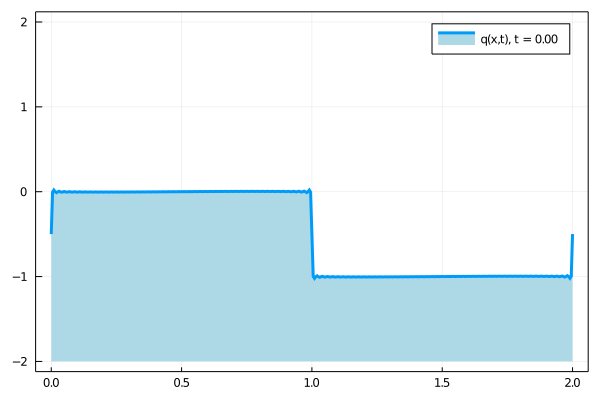

In [29]:
plot(x, U, xaxis = [minimum(x),maximum(x)], yaxis = [-2,2],lw=3,label = @sprintf("q(x,t), t = %1.2f",t), framestyle = :box, fill = (-2,:lightblue))



In [ ]:
x = 0:0.005:2 |> Array
t = 0.01
U = map(x -> KdV(BA,x,t) |> real, x);

In [ ]:
plot(x, U, xaxis = [minimum(x),maximum(x)], yaxis = [-2,2],lw=3,label = @sprintf("q(x,t), t = %1.2f",t), framestyle = :box, fill = (-2,:lightblue))


In [ ]:
using Plots

In [ ]:
x = zs[110,1]:10.:zs[120,1]
d = map(Δ,x)
plot(x,d)
d = map(x -> y2(sqrt(x)), x)
plot!(x,d)
plot!(zs,0*zs, seriestype = :scatter)
plot!(gaps[:,2],map(Δ,gaps[:,2]), seriestype = :scatter, legend = false, xaxis = [minimum(x),maximum(x)])

In [ ]:
x = zs[110,1]:10.:zs[120,1]
d = map(Δ,x)
plot(x,d)
d = map(x -> y2(sqrt(x)), x)
plot!(x,d)
plot!(zs,0*zs, seriestype = :scatter)
plot!(gaps[:,1],map(Δ,gaps[:,1]), seriestype = :scatter, legend = false, xaxis = [minimum(x),maximum(x)])

In [ ]:
gaps[100,1]